# Assignment 1

In this assignment you are tasked to fill this notebook by answering the questions, sometimes you will find questions that require you to type, you can do that by inserting a Markdown cell below the question and type your answer in it.

## Goal:
The goals of this assignment is to:
- Implement, debug and visualize multivariate linear regression to nonlinear data
- Get introduced to the concepts of overfitting and underfitting
- Implementing linear regression with regualrization and understanding the importance of train\test errors

Throughout this assignment you will be using the `Assignment_Data.csv` file.

## Import Libraries and Load Data

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("./Assignment_Data.csv")

## Understand and Visualize the Data

In [7]:
data.head()

,X,Y
0,0.352375,0.089555
1,4.895123,-1.280276
2,1.866624,1.289304
3,3.507061,-0.268157
4,3.380874,-0.206807


In [8]:
data.describe()

,X,Y
count,50.000000,50.000000
mean,3.191593,-0.090497
std,1.839482,0.715067
min,0.100000,-1.333976
25%,1.645796,-0.695994
50%,3.191593,0.015191
75%,4.737389,0.513288
max,6.283185,1.289304


### Question 1
Make a scatter plot to visualize the data, what are your comments?

<AxesSubplot: xlabel='X', ylabel='Y'>

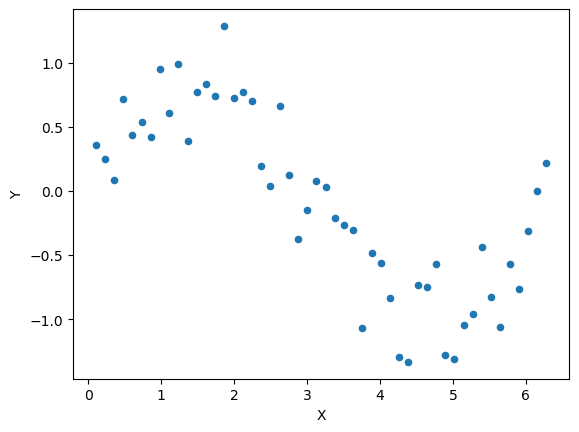

In [10]:
data.plot.scatter('X','Y')
#It seems to be complicated to find a linear model. The data seems to oscillate around 0 such that -1.5 < Y(X) < 1.5 .

As explained in class, linear regression might not be directly suitable for nonlinear data.
However, by doing feature expansion we can still use linear regression techniques to fit nonlinear data. As a result, you will be able to fit the data using different degrees polynomials, e.g. a degree two polynomial (which is a linear combination of $1, x$ and $x^2$), or a degree three polynomial (which is a linear combination of $1, x, x^2$ and $x^3$), etc...

Higher degree polynomials are more expensive to compute and to fit, but can capture finer details in the data, which results in more expressive models.

In [11]:
x = np.array(data['X'])
y = np.array(data['Y'])
print(f'Shape of x {x.shape}')
print(f'Shape of y {y.shape}')

Shape of x (50,)
Shape of y (50,)


## Process the Data

### Question 2
Complete the following function `build_poly()` which is a function that takes the 1D array x as input along with an integer value degree and outputs a 2D array phi that expands x into a polynomial with the associated degree

In [202]:
def build_poly(x, degree):
    """Polynomial expansion of x with the given degree"""
    # write your code in between these two lines
    # ***************************************************
    mat = []
    for q in x:
        poly = []
        for i in range(degree + 1):
            base_vector = q**i
            poly.append(base_vector)
        mat.append(poly)
        phi = np.array(mat)
    # ***************************************************
    return phi

The function `plot_fitted_curve()` is used to plot the learned curve on top of the data point

In [108]:
def plot_fitted_curve(y, x, weights, degree, ax):
    """plot the fitted curve."""
    ax.scatter(x, y, color='b', s=12, facecolors='none', edgecolors='r')
    xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
    tx = build_poly(xvals, degree)
    f = np.dot(tx,weights)
    ax.plot(xvals, f)
    ax.set_xlabel("x")
    ax.set_ylim([-1.5,1.5])
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))

In [109]:
def ToRescaled(x, mean=None, std=None):
    if mean is None:
        mean = np.mean(x)
    if std is None:
        std = np.std(x)
    x_ = (x - mean) / std
    return x_, mean, std
    
def FromRescaled(x_, mean, std):
    x = x_ * std + mean 
    return x

### Question 3
Use the function ToRescaled() to rescale the values of X and Y.

In [116]:
# x_ = ...
x_ , mean_x , std_x = ToRescaled(x)
# y_ = ...
y_ , mean_y , std_y = ToRescaled(y)

## Learning

### Question 4
Complete the function `polynomial_regression_direct()` to implement the direct method of solving linear regression for polynomials of degree 1, 3, 7, and 12. Use `plot_fitted_curve()` to plot the results, and show the MSE for each.

In [204]:
def polynomial_regression_direct():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # write your code in between these two lines
        # ***************************************************
        x_poly = build_poly(x_,degree)
        x_poly_t = np.transpose(x_poly)
        weights = np.dot( np.linalg.inv(np.dot(x_poly_t,x_poly)) , np.dot(x_poly_t,y_) )
        poly = np.dot( x_poly , weights )
        mse = (1/(2*len(x_)))*np.dot( np.ones(len(x_),dtype = np.int32) , (poly - y_)**2 )
        # ***************************************************
        print("Processing {i}th experiment, degree={d}, mse={mse}".format(i=ind + 1, d=degree, mse=mse))
        # plot fit
        plot_fitted_curve(y_, x_, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.show()

Processing 1th experiment, degree=1, mse=0.22218049462857448
Processing 2th experiment, degree=3, mse=0.06671894852149349
Processing 3th experiment, degree=7, mse=0.06219327491957939
Processing 4th experiment, degree=12, mse=0.057629941120700225


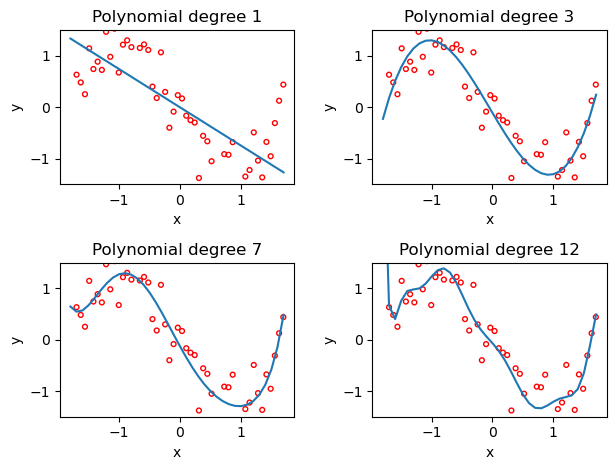

In [205]:
polynomial_regression_direct()

### Question 5
Comment on the values of the MSE

In [ ]:
# write your answer here
# The MSE's values represent how close a fit (the polynomial) is close to the real values in average.
# But it does say if the fit is "overfited" or "underfited".
# Exemple : Polynomial of degree 12 seems to be overfited even if his MSE is the lowest.

### Question 6
Complete the function `polynomial_regression_GradientDescent()` to do the same as Question 4 but by using gradient descent this time.

In [217]:
def polynomial_regression_GradientDescent():
    degrees = [1, 3, 7, 12]
    T = [10000, 10000, 100000, 10000000]   # number of times steps
    alpha = [1.0, 0.01, 0.001, 0.00001]  # learning parameter
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)
    for ind, degree in enumerate(degrees):
        # write your code in between these two lines
        # ***************************************************
        theta = np.zeros(degree+1)
        x_poly = build_poly(x_,degree)
        x_poly_t = np.transpose(x_poly)
        # ***************************************************
        for t in range(T[ind]):
            # write your code in between these two lines
            # ***************************************************
            b = np.dot( x_poly , theta ) - y_ 
            grad = np.dot( x_poly_t , b )
            theta -= alpha[ind]*(1/len(x_))*grad
            # ***************************************************
        poly = np.dot( x_poly , theta )
        J = (1/(2*len(x_)))*np.dot( np.ones(len(x_),dtype = np.int32) , (poly - y_)**2 )

        print("Processing {i}th experiment, degree={d}, mse={loss}".format(i=ind + 1, d=degree, loss=J))
        plot_fitted_curve( y_, x_, theta, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.show()


Processing 1th experiment, degree=1, mse=0.22218049462857448
Processing 2th experiment, degree=3, mse=0.06671894852290657
Processing 3th experiment, degree=7, mse=0.06423834271410318
Processing 4th experiment, degree=12, mse=0.06279802115566896


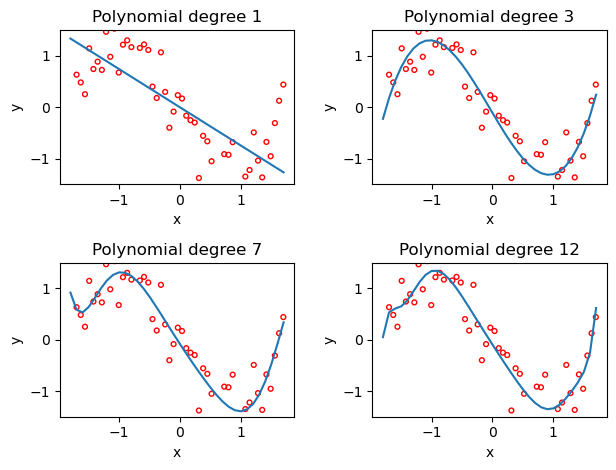

In [218]:
polynomial_regression_GradientDescent()

## Train/Test Split and Evaluation

### Question 7
Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [226]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing, this function returns four arrays
    x & y for training, and x & y for testing
    """
    np.random.seed(seed)
    data_size = len(y)
    # write your code in between these two lines
    # ***************************************************
    split = int(data_size*ratio)
    #i assume that the size of x is the same as the size of y. So i take 'len(x)' but i could take 'len(y)'.
    if (x.ndim == 1):
        train_x = x[:split]
        test_x = x[split:]
    elif (x.ndim == 2):
        train_x = x[:split,:]
        test_x = x[split:,:]
    train_y = y[:split]
    test_y = y[split:]
    # ***************************************************
    
    return train_x, train_y, test_x, test_y

### Question 8
Fill the `train_test_split_demo()` function that splits the data by using the function `split_data()` and then uses the direct method to solve the polynomial regression and prints the split ratio, polynomial degree, the training error, and the testing error.

In [237]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # write your code in between these two lines
    # ***************************************************
    
    x_train , y_train , x_test , y_test = split_data(x, y, ratio, seed)

    x_poly = build_poly(x_train,degree)
    x_poly_t = np.transpose(x_poly)        
    weights = np.dot( np.linalg.inv(np.dot(x_poly_t,x_poly)) , np.dot(x_poly_t,y_train) )
    poly = np.dot( x_poly , weights )
    mse_tr = (1/(2*len(x_train)))*np.dot( np.ones(len(x_train),dtype = np.int32) , (poly - y_train)**2 )

    x_poly = build_poly(x_test,degree)
    x_poly_t = np.transpose(x_poly)        
    weights = np.dot( np.linalg.inv(np.dot(x_poly_t,x_poly)) , np.dot(x_poly_t,y_test) )
    poly = np.dot( x_poly , weights )
    mse_te = (1/(2*len(x_test)))*np.dot( np.ones(len(x_test),dtype = np.int32) , (poly - y_test)**2 )

    # ***************************************************
    
    print("proportion={p}, degree={d}, Training MSE={tr:.3f}, Testing MSE={te:.3f}".format(
          p=ratio, d=degree, tr=mse_tr, te=mse_te))#[0,0] for mse_tr and mse_te ?

Run the cell below to test your functions

In [238]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x_, y_, degree, split_ratio, seed)

proportion=0.9, degree=1, Training MSE=0.237, Testing MSE=0.067
proportion=0.9, degree=3, Training MSE=0.070, Testing MSE=0.007
proportion=0.9, degree=7, Training MSE=0.066, Testing MSE=0.097
proportion=0.9, degree=12, Training MSE=0.062, Testing MSE=0.143
proportion=0.5, degree=1, Training MSE=0.209, Testing MSE=0.169
proportion=0.5, degree=3, Training MSE=0.068, Testing MSE=0.061
proportion=0.5, degree=7, Training MSE=0.054, Testing MSE=0.052
proportion=0.5, degree=12, Training MSE=0.029, Testing MSE=0.042
proportion=0.1, degree=1, Training MSE=0.356, Testing MSE=0.205
proportion=0.1, degree=3, Training MSE=0.001, Testing MSE=0.062
proportion=0.1, degree=7, Training MSE=0.049, Testing MSE=0.057
proportion=0.1, degree=12, Training MSE=0.042, Testing MSE=0.055


### Question 9
Do the training and testing MSE make sense for diffrent ratios? Why? Which one is the best? <br>
What if instead of having 50 samples you had 5000, which split might be best? <br>
Comment on the high testing MSE for 10% split especially with high degree polynomials

In [ ]:
# write your answer here
# ?

## Ridge Regression

The previous exercise shows overfitting when using complex models. Here we will try to correct that by using Ridge Regression. Ridge Regression is very similar to linear regression, the only difference is that we will add to the cost function a regularization term that penalizes high weight values.
$$J(\theta) = \frac{1}{2N}
\left[\sum_{i=1}^N \left(h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \lambda\sum_{j=1}^D {\theta_j}^2\right]$$
With $D$ being the degree of the polynomials used, and $\lambda>0$ the penalty parameter. <br>
Doing that is useful to prevent overfitting when the model used is too complex. <br>
It turns out that Ridge Regression also has closed form solution which is the following:
$$\theta^*_{ridge} = \left(X^T X + \lambda \tilde I\right)^{-1} X^T y $$
Where $\tilde I$ is the diagonal matrix of dimension $D+1$ with $\{0,1\cdots 1\}$ on the diagonal. <br>
In what follows we will be working with polynomials of degree 7 only.

### Question 10
Complete the function `ridge_regression()` that takes the output y, the feature matrix tx, and the penalty parameter $\lambda$ to compute the ridge regression solution weights and the corresponding MSE. You can test the function by setting $\lambda=0$ and check that you should get the same solution as regular multivariate linear regression.

In [246]:
from regex import W


def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # write your code in between these two lines
    # ***************************************************
    x_poly = tx
    x_poly_t = np.transpose(x_poly)
    M , m = tx.shape
    I = np.identity(m)
    I[0,0] = 0
    w = np.dot( np.linalg.inv( np.dot(x_poly_t,x_poly) + lambda_*I) , np.dot(x_poly_t,y) )
    poly = np.dot( x_poly , w )
    Unity = np.ones(m,dtype = np.int32)
    Unity[0] = 0
    mse = (1/(2*M))*(np.sum((poly - y)**2 ) + np.sum(lambda_*(w)**2) - lambda_*(w[0])**2)
    #Processing 3th experiment, degree=7, mse=0.06219327491957939
    # ***************************************************
    return w,mse

In [247]:
def test_ridge_regression():
    degree = 7
    phi = build_poly(x_, degree)
    weights, mse = ridge_regression(y_, phi, 0)
    print("degree={d}, mse={mse}".format(d=degree, mse=mse))

In [248]:
test_ridge_regression()

degree=7, mse=0.06219327491957939


The function `plot_train_test()` is used to plot the train and test errors for different values of $\lambda' = \frac{\lambda}{2N}$

In [219]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambdas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("$\lambda$'")
    plt.ylabel("MSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")

### Question 11
complete the function `ridge_regression_demo()` to run ridge regression with different values of $\lambda'$, run the cell below that to test the function and generate the plot, and comment on the generated plot.

In [249]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    phi = build_poly(x, degree)
    train_x, train_y, test_x, test_y = split_data(phi, y, ratio, seed=seed)

    mse_tr = []
    mse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # write your code in between these two lines
        # ***************************************************
        x_poly = train_x
        x_poly_t = np.transpose(x_poly)
        M , m = train_x.shape
        I = np.identity(m)
        I[0,0] = 0
        w = np.dot( np.linalg.inv( np.dot(x_poly_t,x_poly) + lambda_*I) , np.dot(x_poly_t,train_y) )
        poly = np.dot( x_poly , w )
        mse = (1/(2*M))*(np.sum((poly - train_y)**2 ) + np.sum(lambda_*(w)**2) - lambda_*(w[0])**2)
        mse_tr.append(mse)

        x_poly = test_x
        x_poly_t = np.transpose(x_poly)
        M , m = test_x.shape
        I = np.identity(m)
        I[0,0] = 0
        w = np.dot( np.linalg.inv( np.dot(x_poly_t,x_poly) + lambda_*I) , np.dot(x_poly_t,test_y) )
        poly = np.dot( x_poly , w )
        mse = (1/(2*M))*(np.sum((poly - test_y)**2 ) + np.sum(lambda_*(w)**2) - lambda_*(w[0])**2)
        mse_te.append(mse)
        print(mse)
        # ***************************************************
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training MSE={tr:.3f}, Testing MSE={te:.3f}".format(
            p=ratio, d=degree, l=lambda_, tr=mse_tr[ind], te=mse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(mse_tr, mse_te, lambdas, degree)

0.025903785684327166
proportion=0.5, degree=7, lambda=0.000, Training MSE=0.027, Testing MSE=0.026
0.025978769599701704
proportion=0.5, degree=7, lambda=0.000, Training MSE=0.027, Testing MSE=0.026
0.026103065623345932
proportion=0.5, degree=7, lambda=0.000, Training MSE=0.027, Testing MSE=0.026
0.026263703521078235
proportion=0.5, degree=7, lambda=0.000, Training MSE=0.027, Testing MSE=0.026
0.02641608449492956
proportion=0.5, degree=7, lambda=0.000, Training MSE=0.027, Testing MSE=0.026
0.026524648258681255
proportion=0.5, degree=7, lambda=0.001, Training MSE=0.028, Testing MSE=0.027
0.02658980493792317
proportion=0.5, degree=7, lambda=0.001, Training MSE=0.029, Testing MSE=0.027
0.026630789971708625
proportion=0.5, degree=7, lambda=0.003, Training MSE=0.029, Testing MSE=0.027
0.026667894088447334
proportion=0.5, degree=7, lambda=0.007, Training MSE=0.030, Testing MSE=0.027
0.026719436141243582
proportion=0.5, degree=7, lambda=0.016, Training MSE=0.031, Testing MSE=0.027
0.0268057684

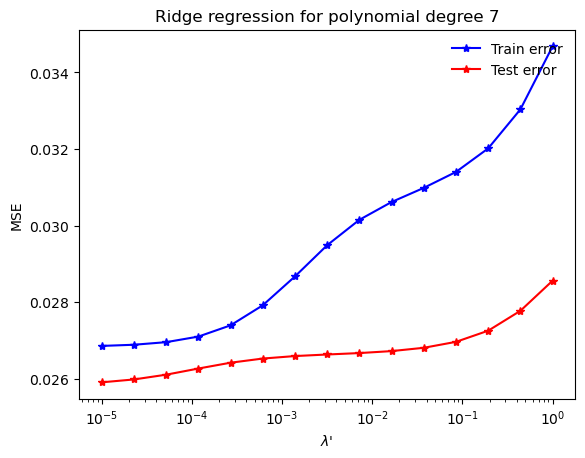

In [250]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)